# Assignment #4

### Creating a recommendation system for Netflix and organizing its audience into clusters.

### Libraries

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import functions
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from functions import min_hash_signatures, get_top5_movies, find_similar_users, recommend_movies

### Loading and investigating the data

In [3]:
df = pd.read_csv('netflix.csv')
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [5]:
df.describe()

,Unnamed: 0,duration
count,671736.00000,6.717360e+05
mean,394640.50000,3.347603e+04
std,193913.62455,1.574396e+05
min,58773.00000,-1.000000e+00
25%,226706.75000,0.000000e+00
50%,394640.50000,1.400000e+01
75%,562574.25000,6.672250e+03
max,730508.00000,1.823725e+07


In [6]:
df.shape

(671736, 8)

In [7]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [8]:
# check for missing values
df.isnull().sum()


Unnamed: 0      0
datetime        0
duration        0
title           0
genres          0
release_date    0
movie_id        0
user_id         0
dtype: int64

In [9]:
# check for duplicates
df.duplicated().sum()

0

### 1. Recommendation System

In [10]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [11]:
# eliminating the clicks with duration 0 as it means the user did not watch the movie and may be it was a miss click
df = df[df['duration'] != 0]
df.head(15)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"Drama, History, War",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"Drama, Horror, Thriller",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"Comedy, Drama",2000-04-14,584bffaf5f,759ae2eac9
13,58786,2017-01-01 21:33:26,38120.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,5b1727dc12
14,58787,2017-01-01 21:37:41,7799.0,Beasts of No Nation,"Drama, War",2015-10-16,c57e11da52,3142b4c730
17,58790,2017-01-01 22:52:08,181.0,Maravilla,"Documentary, Biography, Sport",2014-05-29,19c537b01e,93e9369e81
19,58792,2017-01-01 00:19:40,54195.0,About Last Night,"Comedy, Romance",2014-02-14,f7d088d208,78cdb81c4f
20,58793,2017-01-01 00:49:03,44413.0,Fight Club,Drama,1999-10-15,338abadc17,ac30a85c52


In [12]:
# counting the number of clicks for each movie
number_of_clicks = df['title'].value_counts()
# top 10 movies clicked
top_10_clicked = number_of_clicks[:10]
top_10_clicked

title
Black Mirror: Bandersnatch                      2884
Bright                                          1928
Avengers: Age of Ultron                         1561
Annihilation                                    1536
Bird Box                                        1474
Deadpool                                        1425
Hot Fuzz                                        1368
The Hitman's Bodyguard                          1307
FYRE: The Greatest Party That Never Happened    1203
Captain America: Civil War                      1153
Name: count, dtype: int64

In [13]:
top_10_clicked.index

Index(['Black Mirror: Bandersnatch', 'Bright', 'Avengers: Age of Ultron',
       'Annihilation', 'Bird Box', 'Deadpool', 'Hot Fuzz',
       'The Hitman's Bodyguard',
       'FYRE: The Greatest Party That Never Happened',
       'Captain America: Civil War'],
      dtype='object', name='title')

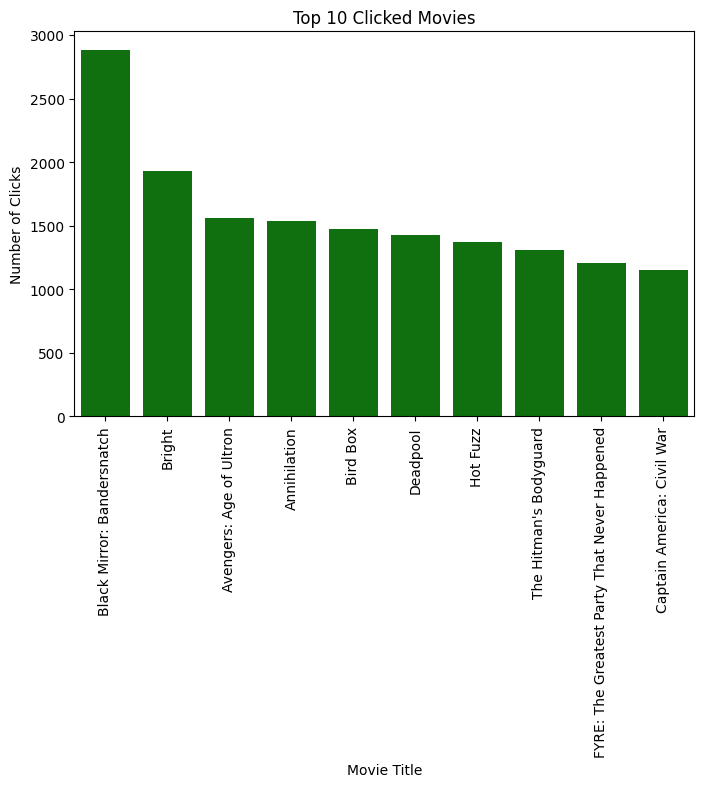

In [14]:
# plotting the top 10 clicked movies
plt.figure(figsize=(8, 5))
sns.barplot(x=top_10_clicked.index, y=top_10_clicked.values, color='green')
plt.title('Top 10 Clicked Movies')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Clicks')
plt.show()


In [15]:
top_10_movies_titles_genres = df[df['title'].isin(top_10_clicked.index)][['title', 'movie_id','genres']]
top_10_movies_titles_genres.drop_duplicates(inplace=True)
top_10_movies_titles_genres = top_10_movies_titles_genres[top_10_movies_titles_genres['genres'] != 'NOT AVAILABLE']

# top 10 clicked movies and their genres
top_10_movies_titles_genres


,title,movie_id,genres
757,Captain America: Civil War,572b55789d,"Action, Adventure, Sci-Fi"
22312,Deadpool,2b83f89fbe,"Action, Adventure, Comedy, Sci-Fi"
38370,Avengers: Age of Ultron,51a1a42126,"Action, Adventure, Sci-Fi"
69379,Hot Fuzz,6467fee6b6,"Action, Comedy, Mystery, Thriller"
221353,Bright,0ca8bc0382,"Action, Fantasy, Thriller"
306179,Annihilation,1f579d43c3,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr..."
323723,The Hitman's Bodyguard,261df73aa6,"Action, Comedy, Crime, Thriller"
508195,Bird Box,b4a3d3b288,"Drama, Horror, Sci-Fi"
514702,Black Mirror: Bandersnatch,e847f14da5,"Drama, Mystery, Sci-Fi, Thriller"
538537,FYRE: The Greatest Party That Never Happened,3a84965f36,"Documentary, Music"


### 1.2 Minhash Signatures

For the hashing process, the uniques genres will be extracted from the "genres" column which will be used as **shinglings**. After that, the users will be aggregated in the same bucket if they have **similar** genres of interest.

In [16]:
# Preprocess genres column
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

# Create a set of unique genres
genres_list = list(set(genre for genres in df['genres'] for genre in genres))


In [17]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9


In [18]:
print('There are',len(genres_list), 'unique genres in the dataset, which are', genres_list)

There are 27 unique genres in the dataset, which are ['Reality-TV', 'Thriller', 'Family', 'Drama', 'Sport', 'War', 'Animation', 'Mystery', 'History', 'Short', 'Music', 'Horror', 'News', 'Musical', 'Crime', 'NOT AVAILABLE', 'Sci-Fi', 'Documentary', 'Romance', 'Talk-Show', 'Biography', 'Western', 'Comedy', 'Film-Noir', 'Action', 'Adventure', 'Fantasy']


In [19]:
# unique user_ids
unique_users = list(df['user_id'].unique())

# Create a binary matrix where each row represents a user, and each column represents a genre
binary_matrix = pd.DataFrame(0, index=genres_list, columns=unique_users)




In [20]:
binary_matrix.shape

(27, 120271)

In [21]:
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Reality-TV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thriller,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Family,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Drama,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Iterate over rows in the original DataFrame
for index, row in df.iterrows():
    user_id = row['user_id']
    genres = row['genres']
    
    # Check if each genre is in the binary_matrix columns
    for genre in genres:
        if genre in binary_matrix.index:
            # Update the corresponding entry to 1
            binary_matrix.loc[genre, user_id] = 1


In [23]:
# Drop the NOT AVAILABLE row from the genres
binary_matrix.drop('NOT AVAILABLE', axis=0, inplace=True)
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Reality-TV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thriller,1,1,1,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
Family,1,1,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
Drama,0,1,1,1,1,0,1,1,1,1,...,1,1,0,0,0,0,0,0,1,0
Sport,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [24]:
binary_matrix.shape

(26, 120271)

In [25]:
np.random.seed(42)  

# number of permutations
perms = len(genres_list)
# number of buckets
num_buckets = 2951
# Convert the binary matrix to a NumPy array
binary_matrix = binary_matrix.to_numpy()

signatures, buckets = min_hash_signatures(binary_matrix, perms, num_buckets)


#### **Justification for the choice of number of buckets:**

For a more tailored recommendation system, the assumption is made that each bucket can represent a genre, two genres, or three genres at most. Since we have 26 unique genres, the number of buckets is calculated as follows:

$$
\text {Number of Buckets} = \binom{26}{1} + \binom{26}{2} + \binom{26}{3} \text {= 2951 Buckets}
$$

### 1.3 Locality-Sensitive Hashing (LSH)

In [26]:
# Example usage
target_user_id = "8e1be40e32"  
most_similar_users = find_similar_users(target_user_id, unique_users, signatures)

print(f"The two most similar users to the user with ID:{target_user_id} are:")
for user_id, similarity in most_similar_users:
    print(f"User ID: {user_id}, Similarity: {similarity}")

The two most similar users to the user with ID:8e1be40e32 are:
User ID: 636a8e8f9e, Similarity: 1.0
User ID: 7fb87fd2b5, Similarity: 0.9335283661679751


In [27]:
user_A_movies = get_top5_movies(most_similar_users[0][0], df, 'A')
user_B_movies = get_top5_movies(most_similar_users[1][0], df, 'B')

In [28]:
user_A_movies

,title,movie_id,clicks,user
0,Food on the Go,aec4b3b4b3,2,A
1,Outlaw King,b1201b04b8,2,A
2,The Ballad of Buster Scruggs,3db668b28a,2,A
3,Nothing to Hide,b9ff1e7d82,1,A
4,Mowgli: Legend of the Jungle,4308bda5af,1,A


In [29]:
user_B_movies

,title,movie_id,clicks,user
0,Dracula Untold,9273567d2d,3,B
1,ParaNorman,de719e654b,2,B
2,Triple Frontier,530a825afd,1,B
3,The Legend of Cocaine Island,3395cdc07c,1,B
4,The Trap,028cd7c4dd,1,B


In [30]:
movies_to_recommend = recommend_movies(user_A_movies, user_B_movies)
print('The recommended movies are:')
for movie in movies_to_recommend:
    print(movie)

The recommended movies are:
Food on the Go
Outlaw King
The Ballad of Buster Scruggs
Nothing to Hide
Mowgli: Legend of the Jungle


## Approach:

### Step 1: Min-Hash Signature Calculation

#### Function: `min_hash_signature(matrix, num_hashes)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.

- **Output:**
  - Min-hash signatures for each user.

- **Explanation:**
  1. For each genre, iterate through users and update the min-hash signature.
  2. Generate random hash functions to create permutations of user indices.
  3. Calculate the min-hash signature for each user by considering their liked genres.
  4. The resulting matrix (`signature_matrix`) contains min-hash signatures for all users.

### Step 2: Bucketing Users Using LSH

#### Function: `min_hash_signatures(matrix, num_hashes, num_buckets)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.
  - Number of buckets `num_buckets`.

- **Output:**
  - Min-hash signatures for each user.
  - Users grouped into buckets.

- **Explanation:**
  1. Extend the previous function to include bucketing logic.
  2. Initialize an empty dictionary (`buckets`) to store user indices for each bucket.
  3. For each genre:
     - Update min-hash signatures for users.
     - Map the min-hash signature to a bucket using a hash function.
     - Add the user to the corresponding bucket in the `buckets` dictionary.


### 3. Bonus: Clustering the users using DBSCAN algorithm

#### **Approach:** Genre-Based User Clustering
##### The clustering is focused on users, leveraging frequency-encoded genres. Only clicks lasting more than 10 minutes are considered to enhance the robustness of our approach against potential miss-clicks.

In [31]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9


In [32]:
# Create a DataFrame with the frequency of each genre for each user
df_frequency_clustering = pd.DataFrame(index = unique_users, columns=genres_list).fillna(0)
df_frequency_clustering.drop('NOT AVAILABLE', axis=1, inplace=True)
df_frequency_clustering.head()



,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Documentary,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy
7cbcc791bf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ebf43c36b6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8e1be40e32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cff8ea652a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Iterate over rows in the original DataFrame
for index, row in df.iterrows():
    user_id = row['user_id']
    genres = row['genres']
    
    # Calculate the frequency for each genre
    for genre in genres:
        # Check if the genre is in the DataFrame columns and if the duration is greater than 10 minutes
        if genre in df_frequency_clustering.columns and row['duration'] > 600:
            df_frequency_clustering.loc[user_id, genre] += 1

In [34]:
df_frequency_clustering.head()

,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Documentary,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy
7cbcc791bf,0,3,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,3,1,1
ebf43c36b6,0,5,1,1,0,0,2,0,0,0,...,0,0,0,1,0,1,0,5,1,0
8e1be40e32,0,4,1,13,0,2,1,0,2,0,...,1,5,0,2,1,3,0,1,1,1
cff8ea652a,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,2,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [35]:
# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_frequency_clustering)



In [56]:
# Set epsilon and min_samples parameters
epsilon = 0.8
min_samples = 30

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

# 'clusters' now contains the cluster assignments for each user
df_frequency_clustering['cluster'] = clusters

In [57]:
df_frequency_clustering.head()

,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy,cluster
7cbcc791bf,0,3,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,3,1,1,-1
ebf43c36b6,0,5,1,1,0,0,2,0,0,0,...,0,0,1,0,1,0,5,1,0,-1
8e1be40e32,0,4,1,13,0,2,1,0,2,0,...,5,0,2,1,3,0,1,1,1,-1
cff8ea652a,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [64]:
print('The users were clustered into',len(df_frequency_clustering['cluster'].unique()), 'clusters.')

The users were clustered into 178 clusters.


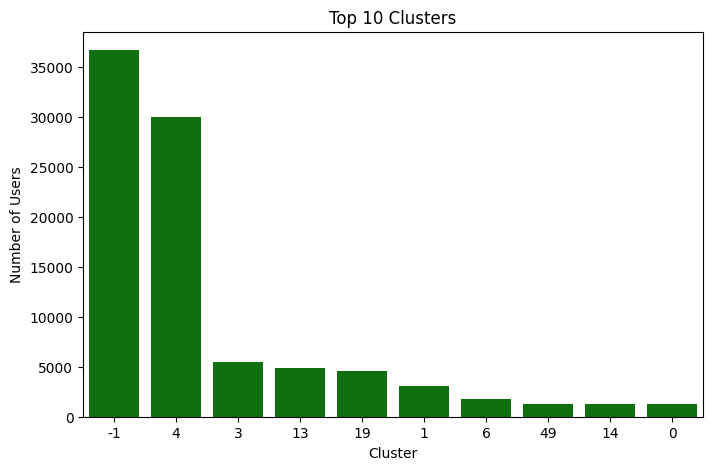

In [59]:
# plot the top 10 clusters
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=df_frequency_clustering, order=df_frequency_clustering['cluster'].value_counts().iloc[:10].index, color='green')
plt.title('Top 10 Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.show()

##### **Comment**

- The users were clustered using DBSCAN into 178 clusters which is much more than the 2 clusters of the Kmeans implemented in the section 2.3.
- The hyperparameters epsilon and minimum number of samples were tuned to minimize the number of clusters and maximize the separations.


##### **Comparison between K-means and DBSCAN**

##### Cluster Shape

- **K-means:** Assumes that clusters are spherical and equally sized. May not perform well on clusters with irregular shapes or varying sizes.
- **DBSCAN:** Can identify clusters with arbitrary shapes and sizes. More flexible in handling clusters of different densities.

##### Number of Clusters

- **K-means:** Requires the user to specify the number of clusters (k) beforehand. Might struggle with datasets where the number of clusters is not known or fixed.
- **DBSCAN:** Automatically determines the number of clusters based on the data's density. Can find clusters of varying sizes and adapt to the data's structure.

##### Parameter Sensitivity

- **K-means:** Sensitive to the initial placement of centroids. May converge to local minima, requiring multiple runs with different initializations.
- **DBSCAN:** Sensitive to parameters such as epsilon (ε) and min_samples.

##### Initialization

- **K-means:** Requires an initial guess for the cluster centroids.
- **DBSCAN:** Requires specifying the parameters epsilon (ε) and min_samples.
